# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje skupa dobijenog automatskom obradom, pre ručne provere i relabeliranja

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('../../data/datasets/action_images_dataset_original_v1.0')):
    X, y = load_data('../../data/datasets/action_images_dataset_original_v1.0', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 2038, Forehands count: 2412, Other count: 6217, Serve count: 1634
All strokes count: 12301


In [8]:
## Uncomment and run this cell with the desired num_examples count
## if you'd like to work with less data for testing purposes

# num_examples = 500
# X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=num_examples, stratify=y, random_state=42)
# X = X_sampled
# y = y_sampled

# bh_cnt = sum([1 for l in y if l == 'backhand'])
# fh_cnt = sum([1 for l in y if l == 'forehand'])
# other_cnt = sum([1 for l in y if l == 'other'])
# serve_cnt = sum([1 for l in y if l == 'serve'])
# print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
# print(f'All strokes count: {len(y)}')

## Isprobavanje stabala odlučivanja

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

In [9]:
start = time.time()

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=7)
clf.fit(X_train, y_train)

end = time.time()
print_time_taken(start, end)

Time taken: 00:06:22.05


In [10]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [11]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.8687895212285456
Precision: 0.8741442103582491
Recall: 0.8496817956296879
F1 Score: 0.8605026609135564

Validation set scores:
Accuracy: 0.8102981029810298
Precision: 0.8133192192873844
Recall: 0.7675044189615328
F1 Score: 0.7861417070067034


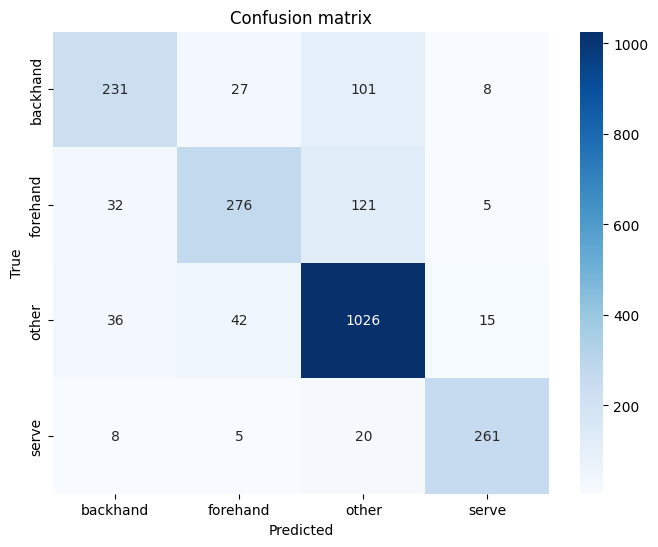

In [12]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.83      0.75      0.79      1467
    forehand       0.86      0.77      0.81      1737
       other       0.86      0.92      0.89      4476
       serve       0.94      0.96      0.95      1176

    accuracy                           0.87      8856
   macro avg       0.87      0.85      0.86      8856
weighted avg       0.87      0.87      0.87      8856



In [14]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.75      0.63      0.69       367
    forehand       0.79      0.64      0.70       434
       other       0.81      0.92      0.86      1119
       serve       0.90      0.89      0.90       294

    accuracy                           0.81      2214
   macro avg       0.81      0.77      0.79      2214
weighted avg       0.81      0.81      0.81      2214



## Pronalaženje najboljih hiperparametara

In [15]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [17]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'gbc__n_estimators': [100],
    'gbc__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'gbc__max_depth': [3, 5],
}

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('gbc', GradientBoostingClassifier(random_state=42))])

Prvo se vrši pretraga prostora za parametre bez opcije `elastic_net`, a onda koristeći `elastic_net` i samo u tom slučaju smisleni `l1_ratio`.

### Analiza hiperparametara

In [18]:
start = time.time()

grid_params_0 = GridSearchCV(grid_model, param_grid=params, scoring='f1_macro', verbose=True,
                             cv=kf, return_train_score=True)#, n_jobs=50)
grid_params_0.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Time taken: 00:18:45.40


In [19]:
best_model = grid_params_0.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_0.best_score_}")
print(f"Best parameters: {grid_params_0.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.7955288823217207
Best parameters: {'gbc__learning_rate': 0.1, 'gbc__max_depth': 5, 'gbc__n_estimators': 100}

Training set scores:
Accuracy: 0.9433434959349594
Precision: 0.9540574289553839
Recall: 0.9323749844329994
F1 Score: 0.9422952820690639

Validation set scores:
Accuracy: 0.9502032520325203
Precision: 0.9564161960820456
Recall: 0.9418043377475036
F1 Score: 0.9487076624282936


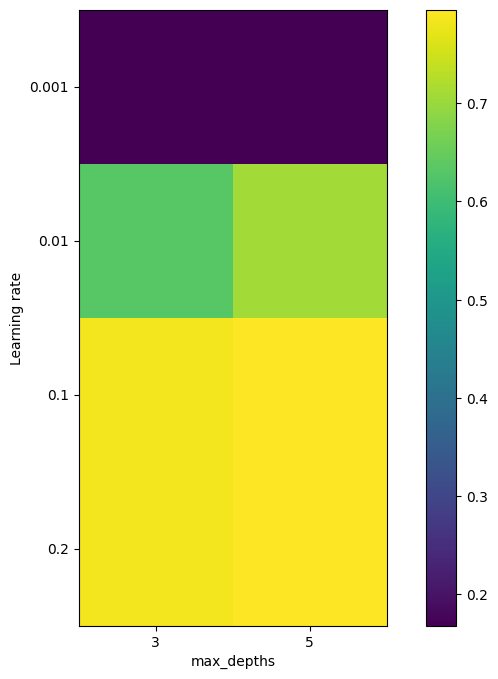

In [20]:
max_depths = params['gbc__max_depth']
learning_rates = params['gbc__learning_rate']

cv_results = pd.DataFrame(grid_params_0.cv_results_)
cv_test_score = cv_results['mean_test_score'].values.reshape(len(learning_rates), len(max_depths))

plt.figure(figsize=(10, 8))

plt.ylabel('Learning rate')
plt.yticks(np.arange(0, len(learning_rates)), learning_rates)

plt.xlabel('max_depths')
plt.xticks(np.arange(0, len(max_depths)), max_depths)

plt.imshow(cv_test_score, cmap='viridis')
plt.colorbar()
plt.show()

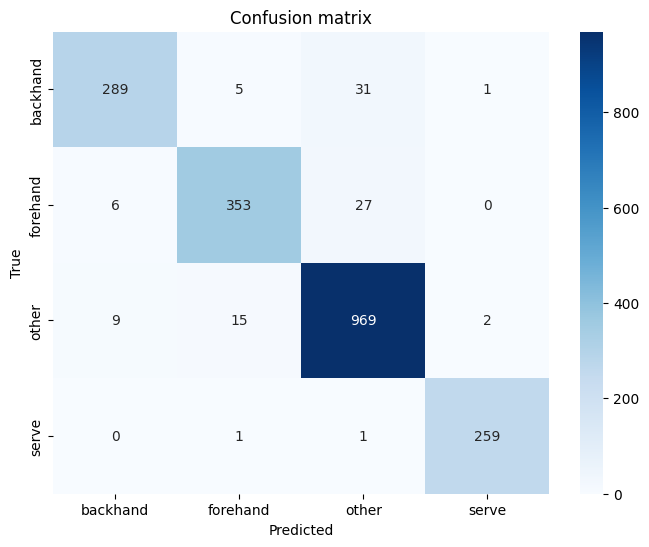

In [21]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.96      0.86      0.91      1304
    forehand       0.95      0.90      0.93      1544
       other       0.93      0.97      0.95      3978
       serve       0.98      0.99      0.99      1046

    accuracy                           0.94      7872
   macro avg       0.95      0.93      0.94      7872
weighted avg       0.94      0.94      0.94      7872



In [23]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.95      0.89      0.92       326
    forehand       0.94      0.91      0.93       386
       other       0.94      0.97      0.96       995
       serve       0.99      0.99      0.99       261

    accuracy                           0.95      1968
   macro avg       0.96      0.94      0.95      1968
weighted avg       0.95      0.95      0.95      1968



Biramo ovaj model koji je i natreniran kao najbolji model, nema potreba da vršimo dalju pretragu. Vidimo da je vrlo verovatno da je model pretrenirao, ali kao i u prethodnim slučajevima, možemo se nadati da će ipak dati sasvim solidne rezultate na test skupu.

## Procena modela na test skupu

In [24]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.8289313287281593
Precision: 0.8262282897187724
Recall: 0.8048828739603548
F1 Score: 0.8144373587100313


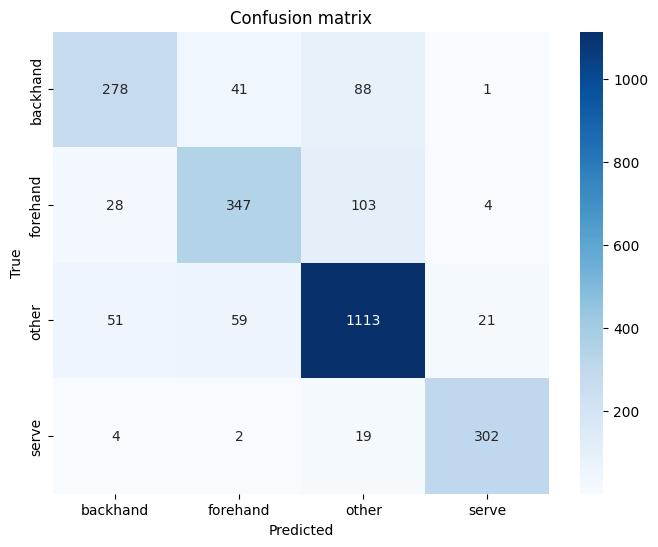

In [25]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.77      0.68      0.72       408
    forehand       0.77      0.72      0.75       482
       other       0.84      0.89      0.87      1244
       serve       0.92      0.92      0.92       327

    accuracy                           0.83      2461
   macro avg       0.83      0.80      0.81      2461
weighted avg       0.83      0.83      0.83      2461



Dobijamo potvrdu da se model ozbiljno preprilagodio, kao što je i bilo očekivano čitajući rezultate iz treninga. Verovatno bi bilo dobro da je nastavljena pretraga, ali to se ovde nije radilo. Ovime i završavamo analizu ovog pristupa, te nećemo raditi za relabelirani skup podataka s obzirom na to da je ponašanje na test skupu razočaralo, a ostale metode su dale značajno bolje rezultate u tom kontekstu, a za neuporedivo manje vreme treniranja.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [28]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/04_boosting_original_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)